run $y_{ui} \sim x_{ui}^T c_i$, where $c_i$ is the category indicator (more than one category is possible)

In [49]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import os
import sqlite3
import sys
import time
import cPickle as pickle
import h5py

from IPython.display import display

import numpy as np
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd

from joblib import Parallel, delayed
from IPython.display import Audio

import librosa
import pmf
import rec_eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
#MSD_clips = '/q/porkpie/porkpie-p6/drspeech/data/MSD_30sec/'

in_dir = '/home/statler/lcharlin/arxiv/dat/dataset_2003-2012/'

In [26]:
id2arxiv_uid = pd.read_csv(in_dir + 'dataset_2003-2012users.tsv', header=None, delimiter='\t', names=['uid', 'arxiv_uid'])

In [27]:
n_users = np.unique(id2arxiv_uid.uid).shape[0]

In [28]:
id2arxiv_info = pd.read_csv(in_dir + 'items_arxiv_info.tsv', header=None, delimiter='\t', names=['arxiv_id', 'categories', 'title', 'date'])

drop papers with no category

In [29]:
drop_indices = id2arxiv_info['categories'].isnull()

drop_indices_list = list(np.where(drop_indices == True)[0])

kept_indices_list = list(np.where(drop_indices == False)[0])

kept_did_list = map(lambda x:x+1, kept_indices_list)

print 'num kept is ' + str(len(kept_did_list))

print 'num dropped indices is ' + str(len(id2arxiv_info[drop_indices]))

id2arxiv_info = id2arxiv_info[~drop_indices]

num kept is 806139
num dropped indices is 19568


In [13]:
items_file = '/home/statler/lcharlin/arxiv/dat/dataset_toy/items.tsv'

In [14]:
items_df = pd.read_csv(items_file, header=None, delimiter='\t', names=['id', 'arxiv_id'])

In [19]:
new_id2arxiv_info = id2arxiv_info.query('arxiv_id in @items_df.arxiv_id')

In [23]:
# write debugging items_arxiv_info file
new_id2arxiv_info.to_csv('/home/statler/lcharlin/arxiv/dat/dataset_toy/items_arxiv_info.tsv', sep='\t', header=None)

In [30]:
unique_did = list(id2arxiv_info.index)

n_docs = np.unique(unique_did).shape[0]

print n_docs, n_users

806139 120297


construct the $c_i$ category indicator matrix

In [31]:
category_df = pd.read_csv(in_dir + 'cats.tsv', delimiter='\t', header=None, names=['category_id', 'category_name'])

In [32]:
n_categories = len(category_df)

In [157]:
theta_shape = (n_docs, n_categories)

In [33]:
document_category_dummies = id2arxiv_info['categories'].str.join(sep='').str.get_dummies(sep=' ')
category_list = list(document_category_dummies.columns)

In [159]:
category_file = list(category_df.category_name)

some categories are not included in cats.tsv because laurent only needed 1 category per paper

In [161]:
for cat in category_dict:
    if cat not in category_file:
        print cat

math.IT
math.MP
q-bio
stat.TH


remove papers with no category

In [332]:
id2arxiv_info.iloc[825682]

arxiv_id      physics/9905630
categories                NaN
title           missing paper
date               0000-00-00
Name: 825683, dtype: object

relabel and make dict for dropped papers

In [34]:
document_category_dummies = document_category_dummies[~id2arxiv_info['categories'].isnull()]

In [35]:
id2arxiv_info = id2arxiv_info[~id2arxiv_info['categories'].isnull()]

In [36]:
document_category_dummies.index

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10, 
            ...
            825667, 825668, 825669, 825676, 825681, 825692, 825696, 825699,
            825703, 825706],
           dtype='int64', length=806139)

In [37]:
raw_idx2dropped_idx = {}
for idx_num, idx in enumerate(document_category_dummies.index):
    raw_idx2dropped_idx[idx] = idx_num

In [60]:
dir_clean = '/home/statler/lcharlin/arxiv/dat/dataset_2003-2012_clean/'


In [44]:
id2arxiv_info.index.map(lambda idx: raw_idx2dropped_idx[idx])

array([     0,      1,      2, ..., 806136, 806137, 806138])

In [46]:
id2arxiv_info.index = id2arxiv_info.index.map(lambda idx: raw_idx2dropped_idx[idx])

In [61]:
id2arxiv_info.to_csv(dir_clean + 'items_arxiv_info.tsv', sep='\t', header=None)

In [62]:
h5f = h5py.File(dir_clean + 'observed_category_array.h5', 'w')

In [63]:
h5f.create_dataset('data', data=observed_categories)

<HDF5 dataset "data": shape (806139, 166), type "<f8">

In [64]:
h5f.close()

In [65]:
h5f2 = h5py.File(dir_clean + 'observed_category_array.h5','r')

In [66]:
obs_cat_loaded = h5f2['data'][:]

In [136]:
# set to 1 for missing category: this doesn't really make sense.
#document_category_dummies['missing_category'] = pd.Series(id2arxiv_info['categories'].isnull().astype(int), index=document_category_dummies.index)
#document_category_dummies = document_category_dummies.drop('missing_category', axis=1)
# set to zero: this is implicit.

scratch that - just use all the categories!:

In [527]:
category_names = list(document_category_dummies.columns)
print category_names

['acc-phys', 'adap-org', 'alg-geom', 'ao-sci', 'astro-ph', 'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR', 'atom-ph', 'bayes-an', 'chao-dyn', 'chem-ph', 'cmp-lg', 'comp-gas', 'cond-mat', 'cond-mat.dis-nn', 'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other', 'cond-mat.quant-gas', 'cond-mat.soft', 'cond-mat.stat-mech', 'cond-mat.str-el', 'cond-mat.supr-con', 'cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH', 'cs.OS', 'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE', 'cs.SI', 'cs.SY', 'dg-ga', 'funct-an', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'math.AC', 'math.AG', 'math.AP', 'math.AT', 'math.CA', 'math.CO', 'math.CT', 'math.CV', 'math.DG', 'math.DS', 'math.FA', 'math.GM', 'math.GN', 'math.

In [53]:
observed_categories = document_category_dummies.as_matrix().astype(np.float64)

In [54]:
observed_categories.shape

(806139, 166)

In [39]:
# check if we have zeros in all rows for some docs

np.where(~observed_categories.any(axis=1))[0]

NameError: name 'observed_categories' is not defined

In [346]:
n_components = 166

write to cleaned directory the:

- train.tsv, test.tsv, validation.tsv

replacing the document id with the dropped document id

In [70]:
def clean_data(f, f_out):
    tp = pd.read_csv(f, delimiter='\t', header=None, names=['uid', 'did', 'count'])
    # convert to zero-based indexing
    tp['uid'] = tp['uid'] - 1
    
    # drop documents with no category
    tp = tp.query('did in @kept_did_list')
    
    # relabel the indices
    tp['did'] = tp['did'].map(lambda x:raw_idx2dropped_idx[x])
    
    print min(tp['did']), max(tp['did']), min(tp['uid']), max(tp['uid'])
    
    tp.to_csv(f_out, sep='\t', header=None, index=False)

clean_data(in_dir + 'train.tsv', dir_clean + 'train.tsv')


0 806138 0 120296


/home/waldorf/altosaar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
clean_data(in_dir + 'validation.tsv', dir_clean + 'validation.tsv')

0 806136 0 120293


/home/waldorf/altosaar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
clean_data(in_dir + 'test.tsv', dir_clean + 'test.tsv')

0 806137 0 120289


/home/waldorf/altosaar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [455]:
def load_data(csv_file, shape=(n_docs, n_users)):
    tp = pd.read_csv(csv_file, delimiter='\t', header=None, names=['uid', 'did', 'count'])
    # /home/statler/lcharlin/arxiv/dat/dataset_2003-2012/items.tsv uses 1-based indexing
    # convert to zero-based
    tp['uid'] = tp['uid'] - 1
    tp = tp.query('did in @kept_did_list')
    #tp['did'] = tp['did'] - 1 # before relabeling and dropping docs with no category
    # drop the documents in the ratings matrix with no category
    tp['did'] = tp['did'].map(lambda x:raw_idx2dropped_idx[x])
    print min(tp['did']), max(tp['did']), min(tp['uid']), max(tp['uid'])
    rows, cols = np.array(tp['did'], dtype=np.int32), np.array(tp['uid'], dtype=np.int32)
    count = tp['count']
    return scipy.sparse.csr_matrix((count,(rows, cols)), dtype=np.int16, shape=shape), rows, cols

In [457]:
train_data, rows, cols = load_data(in_dir + 'train.tsv')

0 806138 0 120296


/home/waldorf/altosaar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [458]:
# binarize the data
train_data.data = np.ones_like(train_data.data)

In [460]:
print train_data.shape
print train_data.data.shape

(806139, 120297)
(29033585,)


In [461]:
vad_smat, rows_vad, cols_vad = load_data(in_dir+'validation.tsv')
# binarize the data
vad_smat.data = np.ones_like(vad_smat.data)

0 806136 0 120293


/home/waldorf/altosaar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [462]:
vad_data = vad_smat.data
vad_data.shape

(7258473,)

In [463]:
vad = dict(X_new=vad_data,
           rows_new=rows_vad,
           cols_new=cols_vad)

In [580]:
coder = pmf.PoissonMF(n_components=166, random_state=98765, verbose=True, a=0.1, b=0.1, c=0.1, d=0.1)

coder.fit(train_data, rows, cols, vad, beta=observed_categories)

initializing beta to be the observed one
ITERATION: 0	Pred_ll: -4.81	Old Pred_ll: -inf	Improvement: nan
ITERATION: 1	Pred_ll: -4.75	Old Pred_ll: -4.81	Improvement: 0.01358
ITERATION: 2	Pred_ll: -4.74	Old Pred_ll: -4.75	Improvement: 0.00126
ITERATION: 3	Pred_ll: -4.74	Old Pred_ll: -4.74	Improvement: 0.00021
ITERATION: 4	Pred_ll: -4.74	Old Pred_ll: -4.74	Improvement: 0.00005


[autoreload of pmf failed: Traceback (most recent call last):
  File "/home/waldorf/altosaar/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'theta' is not defined
]


PoissonMF(max_iter=100, n_components=166, random_state=98765, smoothness=100,
     tol=0.0001, verbose=True)

In [581]:
coder.Et.shape

(166, 120297)

In [582]:
coder.Eb.shape

(806139, 166)

save Et to a file

In [475]:
out_dir = '/home/waldorf/altosaar/projects/arxiv/fit/vanilla-pf-fixed/'

with open(out_dir + 'Et.pkl', 'wb') as f:
    pickle.dump(coder.Et, f)

look at a user's clicks, then at their recommendations

In [583]:
db_dir = '/home/waldorf/altosaar/projects/music-recommendations/dat/'

def get_doc_list(did_list):
    display(id2arxiv_info.iloc[did_list])
#     for did in did_list:
#         doc_row = id2arxiv_info.iloc[did]
#         print("%s\t%s\t%s\t%s" % (doc_row.arxiv_id, doc_row.categories, doc_row.title[0:20], doc_row.date))

    

def get_user_history(train_data, user):
    user_col = train_data.getcol(user)
    sorted_idx = np.argsort(-user_col.data)
    raw_did_list = [idx+1 for idx in user_col.nonzero()[0][sorted_idx]]
    get_doc_list(raw_did_list)

def _compare_his_and_rec(train_data, Eb, Et, user, topk=20):
    print("User preferences:")
    user_df = pd.DataFrame(coder.Et.T[user])
    user_df.index = category_names
    user_df.columns = ['User ' + str(user)]
    user_df.plot(kind='bar', figsize=(30,4))
    plt.show()
    plt.close()
    X_pred = Eb.dot(Et[:, user])
    idx = np.argsort(-X_pred)
    print("User history:")
    get_user_history(train_data, user)
    print("\nRecommendations:")
    get_doc_list([i for i in idx[:topk]])

docs similar to a random doc in hep-ex

In [584]:
id2arxiv_info.iloc[152053]

arxiv_id                                            1107.0239
categories                                             hep-ex
title         The Top Quark Forward Backward Asymmetry at CDF
date                                               2011-07-01
Name: 152277, dtype: object

In [585]:
max_corr_idx = np.argsort(-coder.Eb.dot(coder.Eb[152053]) / 
                          np.sqrt((coder.Eb**2).sum(axis=1)) * np.sqrt((coder.Eb[152053]).sum(keepdims=True)))[:20]
did_list = [idx for idx in max_corr_idx]

get_doc_list(did_list)

,arxiv_id,categories,title,date
37942,1211.1845,hep-ex,Measurement of {\eta} meson production in {\ga...,2012-11-08
161240,1106.3052,hep-ex,Measurement of the t-channel single top quark ...,2011-06-15
118388,0908.1811,hep-ex,Search for charged Higgs bosons in top quark d...,2009-08-12
645300,0707.0118,hep-ex,Proton Structure Functions at High $Q^{2}$ and...,2007-07-01
663204,hep-ex/9910009,hep-ex,Single and Multi-Photon Events with Missing En...,1999-10-02
626002,1212.6194,hep-ex,Search for new physics in events with same-sig...,2012-12-26
401543,1209.4813,hep-ex,Recent Results from BESIII,2012-09-21
24361,1201.6026,hep-ex,Search for WH associated production at D{\o} T...,2012-01-29
161247,1011.3917,hep-ex,Studies of tau- -> eta.K-.nu and tau- -> eta.p...,2010-11-17
219191,1004.3224,hep-ex,First Measurement of the Ratio sigma_(t-tbar) ...,2010-04-19


it seems like for users with little data, the model gives them default preferences in bayes-an, plasma-ph. for users with many papers, it assigns them a large theta in their most-used category, and adjusts preferences accordingly

User preferences:


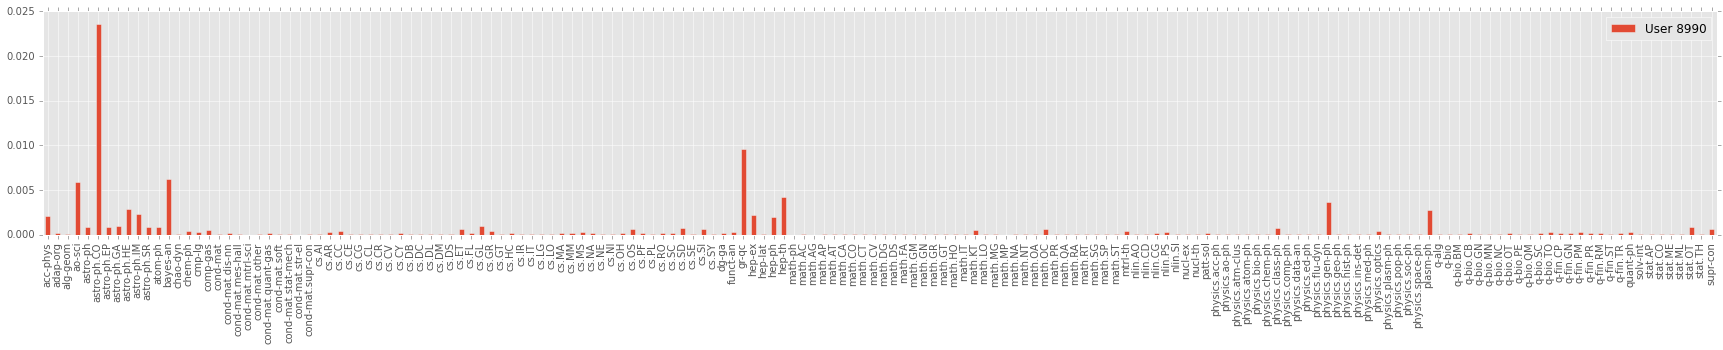

User history:


,arxiv_id,categories,title,date
267,hep-ph/0312264,hep-ph,Two-Loop SUSY Corrections to the Anomalous Mag...,2003-12-18
203437,0910.0659,cond-mat.supr-con cond-mat.mes-hall,Emergence of superconducting textures in two d...,2009-10-04
203055,1005.5503,math.GR math.RT,Sparse fusion systems,2010-05-30
202976,1211.3560,quant-ph,Correlations of entangled quantum states canno...,2012-11-15
202655,hep-ph/0104130,hep-ph,A Note on Regularization methods in Kaluza-Kle...,2001-04-12
202359,0909.2556,cond-mat.dis-nn,Low temperature spin glass fluctuations: expan...,2009-09-14
202089,0904.3588,cs.LO,Termination of Linear Programs with Nonlinear ...,2009-04-22
202039,math/0607464,math.CO math.AG,A cohomological interpretation of Brion's formula,2006-07-19
201962,hep-ph/9608380,hep-ph,Confinement in Light-Front QCD,1996-08-20
201554,1012.5963,gr-qc math-ph math.AP math.MP,Decay of linear waves on higher dimensional Sc...,2010-12-29



Recommendations:


,arxiv_id,categories,title,date
144845,0906.4282,hep-th astro-ph.CO astro-ph.HE gr-qc hep-ph qu...,Logarithmic nonlinearity in theories of quantu...,2009-06-23
139800,0902.4699,astro-ph.CO astro-ph.HE gr-qc hep-ph hep-th,Dark radiation as a signature of dark energy,2009-02-26
91850,0905.0031,hep-ph astro-ph.CO astro-ph.HE gr-qc hep-th,Electrodynamics with Lorentz-violating operato...,2009-04-30
73353,1104.3193,hep-th astro-ph.CO astro-ph.HE gr-qc hep-ph,On the Instability of the Lee-Wick Bounce,2011-04-16
163859,0901.4052,astro-ph.HE astro-ph.CO gr-qc hep-ph hep-th,Probing a Possible Vacuum Refractive Index wit...,2009-01-26
82211,1109.0282,hep-th astro-ph.CO astro-ph.HE gr-qc hep-ph,A Simple Harmonic Universe,2011-09-01
276618,0903.5297,astro-ph.CO astro-ph.HE gr-qc hep-ph hep-th,Impact of Lorentz violation on the dynamics of...,2009-03-30
75696,0911.3363,gr-qc astro-ph.CO astro-ph.HE hep-ph hep-th,Spinning Black Holes as Particle Accelerators,2009-11-17
7427,0905.3170,hep-th astro-ph.CO astro-ph.HE gr-qc hep-ph,Self-dual Black Holes in LQG: Theory and Pheno...,2009-05-20
33320,0906.1735,astro-ph.HE astro-ph.CO gr-qc hep-ph hep-th,Searching for New Physics with Ultrahigh Energ...,2009-06-09


In [586]:
_compare_his_and_rec(train_data, coder.Eb, coder.Et, 8990)

User preferences:


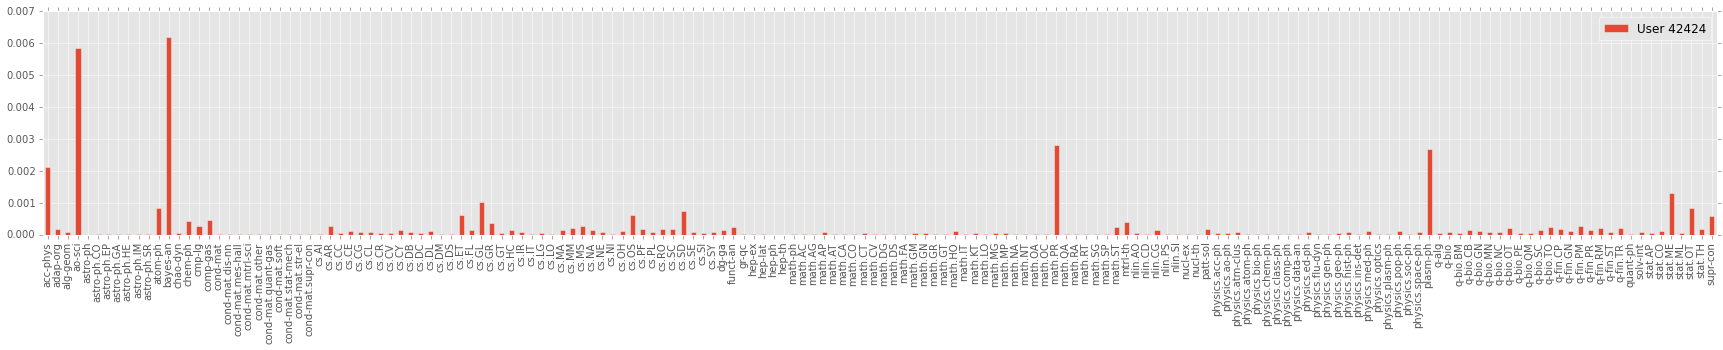

User history:


,arxiv_id,categories,title,date
13866,1102.0703,astro-ph.CO,The Magellanic Quasars Survey. I. Doubling the...,2011-02-03
320379,1105.4563,math.ST stat.TH,Covariance matrix estimation for stationary ti...,2011-05-23
324975,1111.0435,physics.flu-dyn,Drop impact on superheated surfaces,2011-11-02
330908,hep-th/0210095,hep-th,Yang-Baxter $\sigma$-models and dS/AdS T-duality,2002-10-10
336308,math/0501044,math.AP math.DS,A sharp weighted Wirtinger inequality,2005-01-04
340298,0907.3658,hep-ex,Neutrino Physics & The Solar Neutrino Problem,2009-07-21
350874,cond-mat/9910328,cond-mat hep-th,Quantized Skyrmion Fields in 2+1 Dimensions,1999-10-21
381276,hep-th/9505081,hep-th,Singularities on the World Sheets of Open Rela...,1995-05-13
389983,math/0509573,math.AP,Global wellposedness of the modified Benjamin-...,2005-09-23
396745,0809.3658,cond-mat.supr-con cond-mat.str-el,Magnetic mechanism of quasiparticle pairing in...,2008-09-22



Recommendations:


,arxiv_id,categories,title,date
634879,comp-gas/9605001,comp-gas ao-sci chao-dyn nlin.CD nlin.CG,"Estimating the Fractal Dimension, K_2-entropy,...",1996-05-13
120820,cond-mat/9601030,cond-mat adap-org bayes-an nlin.AO,"Statistical Inference, Occam's Razor and Stati...",1996-01-09
617118,adap-org/9601001,adap-org bayes-an nlin.AO,A Geometric Formulation of Occam's Razor for I...,1996-01-08
70601,physics/9611016,physics.data-an astro-ph bayes-an hep-ph nucl-ex,A Theory of Measurement Uncertainty Based on C...,1996-11-21
454089,hep-ph/9512295,hep-ph astro-ph bayes-an cond-mat physics.data-an,Probability and Measurement Uncertainty in Phy...,1995-12-11
92166,bayes-an/9506004,bayes-an hep-lat physics.data-an,Suppressing Random Walks in Markov Chain Monte...,1995-06-22
620066,bayes-an/9604001,bayes-an physics.data-an,Bayes linear variance adjustment for time series,1996-04-02
568533,bayes-an/9512001,bayes-an physics.data-an,Bayes linear covariance matrix adjustment,1995-12-04
675254,bayes-an/9601001,bayes-an physics.data-an,Toward general solutions to time-series proble...,1996-01-07
436308,bayes-an/9511001,bayes-an physics.data-an,Bayesian Method of Moments (BMOM) Analysis of ...,1995-11-30


In [587]:
_compare_his_and_rec(train_data, coder.Eb, coder.Et, 42424)

<Container object of 100 artists>

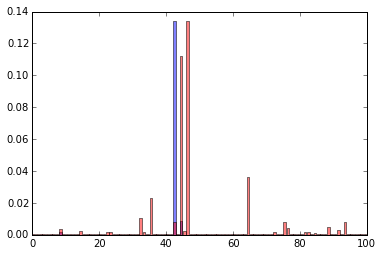

In [21]:
plt.bar(np.arange(100), coder.Eb[53772], alpha=0.5)

plt.bar(np.arange(100), coder.Eb[53772].max()/coder.Eb[358731].max() * coder.Eb[358731], color='red', alpha=0.5)

In [23]:
test_smat, rows_test, cols_test = load_data(in_dir + 'in.test.num.csv')
# binarize the data
test_smat.data = np.ones_like(test_smat.data)

In [20]:
#def play_30sec_clip(tid_7digital):
#    y, sr = librosa.load(os.path.join(MSD_clips, '/'.join(tid_7digital[:2]), '%s.clip.mp3' % tid_7digital))
#    return Audio(y, rate=sr)

#def play_30sec_clip(tid):
#    y, sr = librosa.load(os.path.join(MSD_clips, 'songs_msd', '/'.join(tid[2:5]), '%s.clip.mp3' % tid))
#    return Audio(y, rate=sr)

In [498]:
_compare_his_and_rec(train_data, coder.Eb, coder.Et, 0)

User history:
1006.4053	quant-ph	Quantum entanglement	2010-06-21
0709.2440	hep-th gr-qc math.DG	Time-Dependent Multi	2007-09-15
0912.2345	astro-ph.HE astro-ph.CO gr-qc	Filling the disk hol	2009-12-11
astro-ph/9910109	astro-ph	The impact hazard fr	1999-10-06
1210.4619	cond-mat.supr-con	Superconductivity in	2012-10-16
0801.0402	astro-ph	A sub-AU outwardly t	2008-01-02
cond-mat/0510540	cond-mat.str-el	Self-localization of	2005-10-20
cond-mat/0202487	cond-mat.stat-mech cond-mat.supr-con	Screened Vortex Latt	2002-02-26
hep-ph/0111085	hep-ph hep-th	Charge and Color Bre	2001-11-07
0903.1446	math.DG math-ph math.MP	The two ways of gaug	2009-03-08
1103.3070	astro-ph.SR	Spectroscopy of BL C	2011-03-15
1106.2944	math.CO cs.DM	Matroids and log-con	2011-06-15
cond-mat/0507060	cond-mat.stat-mech	Intermittency of vel	2005-07-04
0902.4621	cond-mat.mtrl-sci	Modeling edge effect	2009-02-26
0802.0215	math.AG	Real mixed Hodge str	2008-02-03
0903.3410	hep-ph	B-Decay Signatures o	2009-03-19
astro-ph/0503596

KeyError: 706127

In [499]:
raw_idx2dropped_idx[706127]

KeyError: 706127

In [512]:
drop_indices[706127]

True

In [510]:
id2arxiv_info.iloc[706127]

arxiv_id                                              1002.1590
categories                                      math-ph math.MP
title         Homoclinic standing waves in focussing DNLS eq...
date                                                 2010-02-08
Name: 710012, dtype: object

In [26]:
_compare_his_and_rec(train_data, coder.Eb, coder.Et, 5000)

User history:
ECHONEST_ID: TRTNFLQ128F92FD031	Neon	BY	John Mayer
ECHONEST_ID: TROFAON128E079371E	(They Long To Be) Close To You	BY	Carpenters
ECHONEST_ID: TRZRXRD128F931113D	Wavin'  Flag	BY	K'Naan
ECHONEST_ID: TRANBUW128F933C645	Don't Panic	BY	Coldplay
ECHONEST_ID: TRHNFTF128F4259CDE	Stay Free	BY	The Clash
ECHONEST_ID: TRLUMTZ128F93297ED	We Can Work It Out	BY	Stevie Wonder
ECHONEST_ID: TRIOTLQ128E0789D3B	X & Y	BY	Coldplay
ECHONEST_ID: TRKMGVX128F148725A	Motion Sickness	BY	Bright Eyes
ECHONEST_ID: TRHPTMT128F92F28D1	Take A Bow	BY	Rihanna
ECHONEST_ID: TRMNOXI128F92F9916	You've Got The Love	BY	Florence + The Machine
ECHONEST_ID: TRFQOSP128F427C2B2	Canada	BY	Five Iron Frenzy
ECHONEST_ID: TRENTGL128E0780C8E	Clocks	BY	Coldplay
ECHONEST_ID: TRPELLJ128F9321962	1234	BY	Feist
ECHONEST_ID: TRYCKII128F9338134	Observándonos (Satélites)	BY	Soda Stereo
ECHONEST_ID: TRPZPXH128F4296171	The District Sleeps Alone Tonight (Album)	BY	Postal Service
ECHONEST_ID: TRQAGHX128F425EEBD	The Way You Make Me Feel	B

In [25]:
play_30sec_clip('2951705')

In [27]:
train_t = train_data.transpose().tocsr()
vad_t = vad_smat.transpose().tocsr()
test_t = test_smat.transpose().tocsr()

In [28]:
Et = np.ascontiguousarray(coder.Et.T)
Eb = np.ascontiguousarray(coder.Eb.T)

In [29]:
res = list()
start_t = time.time()
for i, user_idx in enumerate(rec_eval.user_idx_generator(n_users, 1000), 1):
    res.append(rec_eval.precision_at_k_batch(train_t, vad_t, test_t, 
                                                 Et, Eb, user_idx))
    sys.stdout.write('\rProgress: %d/%d\t Time: %.2f sec/batch' % (user_idx.stop, n_users, (time.time() - start_t) / i))
    sys.stdout.flush()

Progress: 1019318/1019318	Time: 18.30 sec/batch

In [30]:
mn_prec = np.hstack(res)

In [31]:
mn_prec[~np.isnan(mn_prec)].mean()

0.0834313112483583

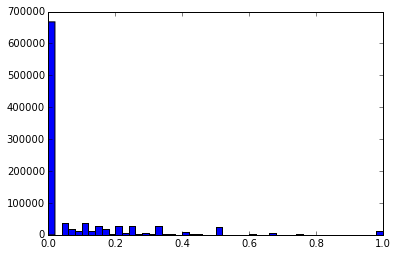

In [32]:
plt.hist(mn_prec[~np.isnan(mn_prec)], bins=50)
pass

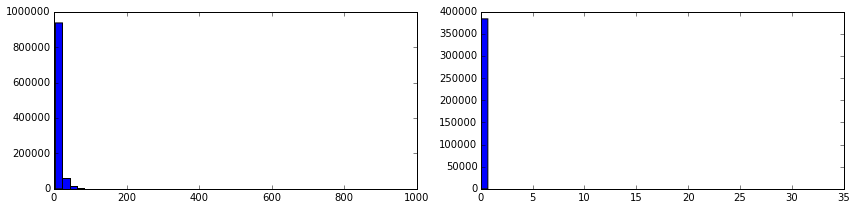

In [33]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist(np.sqrt((Et**2).sum(axis=1)), bins=50)
plt.subplot(122)
plt.hist(np.sqrt((Eb**2).sum(axis=0)), bins=50)
plt.tight_layout()
pass

In [34]:
pmf_binary_params = dict(
    nu_t=coder.gamma_t,
    rho_t=coder.rho_t)

In [35]:
from scipy import io

In [37]:
out = '/home/waldorf/altosaar/projects/music-recommendations/fit/02/'

io.savemat(out + 'pmf_tasteProfile_binary-params-jaan.mat', pmf_binary_params)
np.save(out + 'mn_prec_pmf_binary.npy', mn_prec)
